In [397]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.cluster import DBSCAN

%matplotlib inline

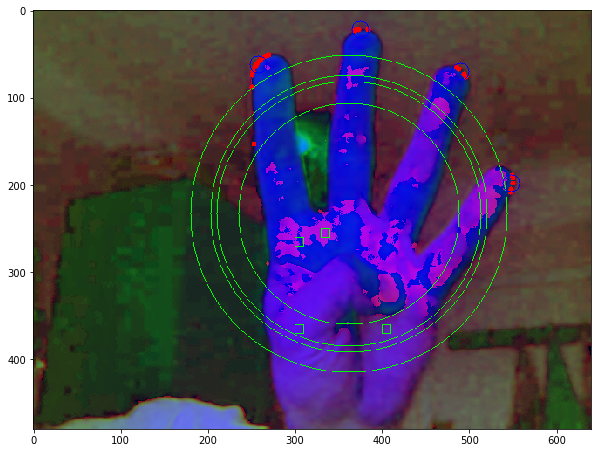

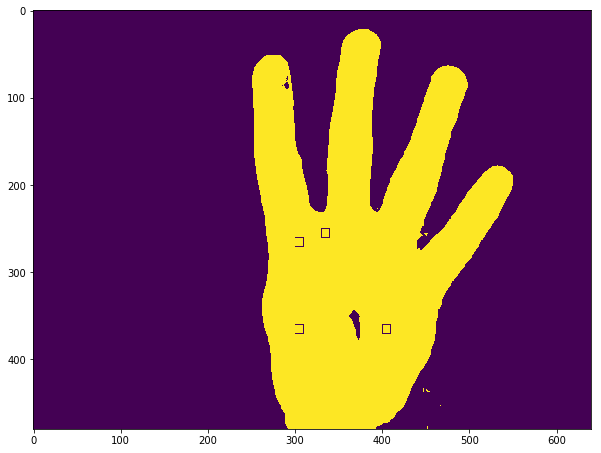

CPU times: user 1.83 s, sys: 370 ms, total: 2.2 s
Wall time: 2.83 s


In [398]:
%%time

image = './memage2.jpg'
kernel = np.ones((3,3),np.uint8)
image = cv2.imread(image)
image2 = image.copy()

image = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

frame3 = image[330:340,250:260]
cv2.rectangle(image,(330,250),(340,260),(0,255,0))
frame4 = image[300:310,260:270]
cv2.rectangle(image,(300 ,260), (310, 270),(0,255,0))
frame5 = image[300:310,360:370]
cv2.rectangle(image,(300 ,360), (310, 370),(0,255,0))
frame6 = image[400:410,360:370]
cv2.rectangle(image,(400 ,360), (410, 370),(0,255,0))
# hsv ranges for hand skin
lower_skin = np.array([0,0,80], dtype=np.uint8)
upper_skin = np.array([255,80,255], dtype=np.uint8)
mask = cv2.inRange(image, lower_skin, upper_skin)



contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

max_contour = max(contours,key=lambda x: cv2.contourArea(x))
cnt = contours[0] # delete excess dim for list
max_hull = cv2.convexHull(max_contour)
epsilon = 0.005*cv2.arcLength(max_contour,True)
approx= cv2.approxPolyDP(max_contour,epsilon,True)

center = np.mean(max_hull, axis=0,dtype=np.uint32)
cx, cy = tuple(center[0])



plt.figure(figsize=(10, 10))
plt.imshow(final) #cmap='gray', interpolation='nearest')
plt.figure(figsize=(10,10))
plt.imshow(mask)

plt.show()

CPU times: user 121 ms, sys: 0 ns, total: 121 ms
Wall time: 143 ms


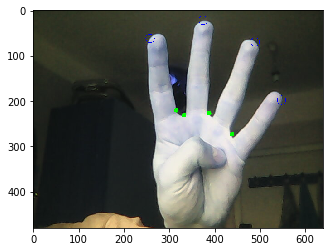

In [401]:
%%time
image3 = image2.copy()
imp_points = []
around_points = []
for num, i in enumerate(approx):
    count = 0 
    for j in max_hull:
        if np.linalg.norm(j-i) < 90 and np.linalg.norm(j-i) > 0:
            count+=1   
    if count < 1:
        x, y = i.ravel()
        cv2.circle(image3, (x,y), 5 ,(0,255,0),-1)
        imp_points.append((x,y))
    
max_hull_top = np.array([i[0] for i in max_hull if i[0][1] < center[0][1]])
clustering = DBSCAN(eps=14, min_samples=1).fit(max_hull_top)
labels = clustering.labels_

for i in np.unique(labels):
    if i >= 0 and np.count_nonzero(labels==i) >= 2:
        array = []
        for num, j in enumerate(labels):
            if j == i:
                array.append(max_hull_top[num])
        if array != []:
            ax,ay = tuple(np.squeeze(np.mean(np.array(array),axis=0)))
            cv2.circle(image3,(int(ax),int(ay)) ,10, (0,0,255), 1)
            
plt.imshow(image3)

In [404]:
max_hull_top

array([[550, 198],
       [548, 205],
       [547, 208],
       [253, 153],
       [251,  88],
       [251,  74],
       [252,  70],
       [254,  65],
       [256,  62],
       [259,  58],
       [261,  56],
       [265,  53],
       [267,  52],
       [270,  51],
       [369,  23],
       [373,  22],
       [384,  22],
       [485,  65],
       [488,  67],
       [494,  73],
       [496,  76],
       [549, 189],
       [550, 192]], dtype=int32)

In [287]:
max_hull_top_graph = np.expand_dims(max_hull_top,axis=1)

In [358]:
%%time
clustering = DBSCAN(eps=14, min_samples=1).fit(np.squeeze(max_hull_top,axis=1))

CPU times: user 2.06 ms, sys: 7.65 ms, total: 9.71 ms
Wall time: 364 ms


In [406]:
max_hull.shape

(39, 1, 2)

CPU times: user 84 ms, sys: 20 ms, total: 104 ms
Wall time: 89.4 ms


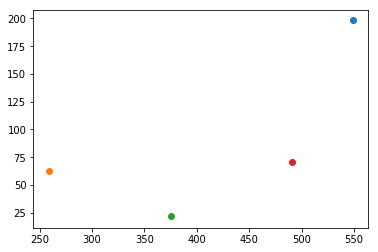

In [371]:
%%time
labels = clustering.labels_
for i in np.unique(labels):
    if i >= 0 and np.count_nonzero(labels==i) >= 2:
        array = []
        for num, j in enumerate(labels):
            if j == i:
                array.append(max_hull_top[num])
        tup = tuple([(np.mean(np.array(array),axis=0)[:,0],np.mean(np.array(array),axis=0)[:,1])])
        #print(np.mean(np.array(array),axis=0))
        plt.scatter(np.mean(np.array(array),axis=0)[:,0],np.mean(np.array(array),axis=0)[:,1])

In [162]:
leftmost = max_hull[max_hull[:,:,0].argmin()][0]
rightmost = max_hull[max_hull[:,:,0].argmax()][0]
topmost = max_hull[max_hull[:,:,1].argmin()][0]
bottommost = max_hull[max_hull[:,:,1].argmax()][0]

hdis = np.linalg.norm(leftmost-rightmost)
vdis = np.linalg.norm(topmost-bottommost)

hull = cv2.convexHull(cnt, returnPoints=False)
defects = cv2.convexityDefects(cnt, hull)

final = cv2.drawContours(image, max_hull_top, -1, (255, 0, 0), 5)
#final = cv2.drawContours(image, approx, -1, (0,255,0),5)
circles = [hdis//2,vdis//3, vdis//2.5, hdis//2.5]
for i in circles:
    cv2.circle(final,(cx, cy), int(i), (0,255,0),1)